# Blind Sentiment Analysis in Arabic
### By McClain Thiel for LSE summer course Machine learing in practice ME315

importing basic ml and ds libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import glob
import os

Origninally,  this data set was two folders. One was 1000 txt files of positive tweets, the the other was 1000 txt files of negative tweets. The following is just code to crawl over that dataset and feed it into a dataframe. I then saved it as a csv to make it easier to work with and transfer to R. This code below is no longer nesessary with the addition of the data.csv.

In [4]:
#df = pd.concat([pd.read_csv(f) for f in glob.glob('Twitter/Positive/*.txt')], ignore_index = True)


#positive = list(df.columns)

#data = {'Text' : np.append(positive,negitive),
        #'Positive?' : np.append(np.ones(len(positive), np.zeros(len(negitive))))}
    
#df2 = pd.concat([pd.read_csv(f) for f in glob.glob('Twitter/Negative/*.txt')], ignore_index = True)
#lst = []
#for f in glob.glob('Twitter/Negative/*.txt'):
    #print(f)
 #   lst.append(pd.read_csv(f))
    
#df2 = pd.concat(lst)
#negitive = list(df2.columns)

#data = {'Text' : np.append(positive,negitive),
       # 'Positive?' : np.append(np.ones(len(positive)), np.zeros(len(negitive)))}

#master = pd.DataFrame(data=data)

#master.to_csv('data.csv')


In [5]:
master = pd.read_csv('data.csv')

A few natural language processing libraries for Arabic text

In [6]:
import pyarabic.araby as ar
import pyarabic.number as arnum
import nltk.stem.arlstem as nlp
import nltk

Functions to normalize and clean the tweets. Wrapper functions in this document are just there to make the actual function work with the .apply functionality of dataframes.

In [7]:
def normalize(word):
    stemmer = nlp.ARLSTem()
    return stemmer.stem(word)

def clean_and_tokenize(string):
    tokenizer = nltk.tokenize.TweetTokenizer()
    words = tokenizer.tokenize(string) #returns list
    return [normalize(x) for x in words]

def wrapper(row):
    return clean_and_tokenize(row['Text'])

def to_string(lst):
    return ''.join(lst)

def wrapper2(row):
    return to_string(row['token'])

In [8]:
master.head()

,Unnamed: 0,Text,Positive?
0,0,أبذل الجهد و العرق و توكل على الله و اطمئن فر...,1.0
1,1,احُبك ربي,1.0
2,2,اللهم عفوك و رضاك و الجنه,1.0
3,3,الماء هى الحياة,1.0
4,4,بالفعل لازم كل واحد بيتكلم عن الدين اقل مافيه...,1.0


In [9]:
master['token'] = master.apply(wrapper, axis=1)
master = master[~master.Text.str.contains('Unnamed')]
master['c_string'] = master.apply(wrapper2, axis=1)


In [10]:
#build word index
from itertools import zip_longest
from nltk.corpus import stopwords

def create_dict(keys, values):
    return dict(zip_longest(keys, values[:len(keys)]))


words = set()
for x in master['token']:
    for y in x:
        words.add(y)
        
index = np.arange(0,len(words))


word_index = create_dict(words, index)

words_no_stopwords = set()
for x in master['token']:
    for y in x:
        if y not in stopwords.words():
            words_no_stopwords.add(y)
        
index1 = np.arange(0,len(words_no_stopwords))

words_without_stop = create_dict(words_no_stopwords, index1)


In [11]:
from sklearn.model_selection import train_test_split

def token_to_number(lst):
    return [words_without_stop[x] for x in lst if x in words_without_stop]

def wrapper3(row):
    return token_to_number(row['token'])

master['int_rep'] = master.apply(wrapper3, axis=1)

train, test = train_test_split(master, test_size=.2)
x_train, x_test = train['int_rep'], test['int_rep']
y_train, y_test = train["Positive?"], test['Positive?']


print('Maximum review length: {}'.format(
len(max((x_train), key=len))))

from keras.preprocessing import sequence
max_words = 175
X_train = sequence.pad_sequences(x_train, maxlen=max_words)
X_test = sequence.pad_sequences(x_test, maxlen=max_words)


Maximum review length: 160


Using TensorFlow backend.


In [12]:
#bag of words

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


nb = Pipeline([#('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])


nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

accuracy = 100*sum(y_pred == y_test)/len(y_test)
print('accuracy is (%)', accuracy)
print(classification_report(y_test, y_pred,target_names=['yes', 'no']))


accuracy is (%) 54.3640897755611
              precision    recall  f1-score   support

         yes       0.66      0.23      0.34       206
          no       0.52      0.87      0.65       195

   micro avg       0.54      0.54      0.54       401
   macro avg       0.59      0.55      0.50       401
weighted avg       0.59      0.54      0.49       401



In [13]:
master
pos = master[master['Positive?'] == 1]
neg = master[master['Positive?'] == 0]

total_words = sum([len(x) for x in master['token']])
total_words 



def build_bag(arr):
    stop_words = 0
    bag = {}
    for x in arr:
        for y in x:
            if y in stopwords.words():
                stop_words +=1
            elif y in bag:
                bag[y] += 1
            else:
                bag[y] = 1
    print(stop_words)
    return bag
pos_w = build_bag(pos['token'])
neg_w = build_bag(neg['token'])

pos_words = pd.DataFrame(data={'word': list(pos_w.keys()),'occurences': list(pos_w.values())})
neg_words = pd.DataFrame(data={'word': list(neg_w.keys()),'occurences': list(neg_w.values())})

single_occ_words_neg = neg_words[neg_words['occurences'] == 1].shape[0]
single_occ_words_pos = pos_words[pos_words['occurences'] == 1].shape[0]

pos_words = pos_words[pos_words['occurences'] > 1]
neg_words = neg_words[neg_words['occurences'] > 1]

pos_words['log_p'] = [np.log(x/total_words) for x in pos_words['occurences']] 
pos_words = pos_words.sort_values(by='log_p', ascending=False)
neg_words['log_p'] = [np.log(x/total_words) for x in neg_words['occurences']] 
neg_words = neg_words.sort_values(by='log_p', ascending=False)

1271
1294


In [14]:
c1, c2 = [], []
for x in pos_words['word']:
    if x in list(neg_words['word']):
        p1 = float(pos_words[pos_words['word'] == x]['log_p'])
        p2 = float(neg_words[neg_words['word'] == x]['log_p'])
        c1.append(x)
        c2.append(abs(p1-p2))
        
d = {'word':c1,
     'dif': c2}
words_ = pd.DataFrame(data=d).sort_values(by = ['dif'], ascending=False)[:13]['word']
arb = [words_[5], words_[6], words_[9], words_[11], words_[246], words_[18], words_[21], words_[30], words_[10], words_[13]]
#negitive values mean  word leans rare in negitive therefore highly positive
#words_

In [15]:
#retrying naive bayes with a slight modification
def n_bayes(tweet, c):
    p_p, p_n = 0, 0
    for x in tweet:
        if x in list(pos_words['word']):
            p_p += float(pos_words[pos_words['word'] == x]['log_p'])
        else:
            p_p += c
            
        if x in list(neg_words['word']):
            p_n += float(neg_words[neg_words['word'] == x]['log_p'])
        else:
            p_n += c
            
        if p_p > p_n:
            return 0
        else:
            return 1
        
def n_b_wrapper(row):
    return n_bayes(row['token'], 3)

sum(master.apply(n_b_wrapper, axis=1) == master['Positive?'])/master.shape[0]

0.5941088367448827

In [16]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Sequential

embedding_size=32
vocab_size = len(word_index)

model = Sequential([
    Embedding(vocab_size, embedding_size, input_length=max_words, name = 'embedding_layer'),
    LSTM(100, name = 'recurrent_layer'),
    Dense(1, activation='sigmoid', name = 'output_layer'),
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 175, 32)           141184    
_________________________________________________________________
recurrent_layer (UnifiedLSTM (None, 100)               53200     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 101       
Total params: 194,485
Trainable params: 194,485
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

batch_size = 64
num_epochs = 7
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
history = model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Train on 1538 samples, validate on 64 samples
Epoch 1/7
1538/1538 [==============================] - 8s 5ms/sample - loss: 0.6912 - accuracy: 0.5280 - val_loss: 0.6888 - val_accuracy: 0.5625
Epoch 2/7
1538/1538 [==============================] - 5s 3ms/sample - loss: 0.6471 - accuracy: 0.7679 - val_loss: 0.5833 - val_accuracy: 0.7500
Epoch 3/7
1538/1538 [==============================] - 5s 3ms/sample - loss: 0.7618 - accuracy: 0.8303 - val_loss: 0.5682 - val_accuracy: 0.7656
Epoch 4/7
1538/1538 [==============================] - 5s 3ms/sample - loss: 0.3983 - accuracy: 0.9187 - val_loss: 0.6106 - val_accuracy: 0.6250
Epoch 5/7
1538/1538 [==============================] - 5s 3ms/sample - loss: 0.2796 - accuracy: 0.9226 - val_loss: 0.3995 - val_accuracy: 0.8438
Epoch 6/7
1538/1538 [==============================] - 6s 4ms/sample - loss: 0.1835 - accuracy: 0.9649 - val_loss: 0.3773 - val_accuracy: 0.8281
Epoch 7/7
1538/1538 [==============================] - 7s 5ms/sample - loss: 0.1258 

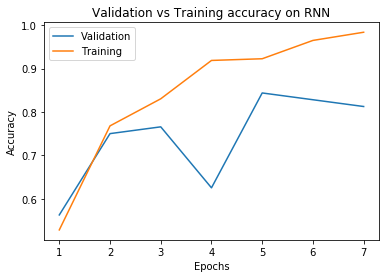

In [18]:
train_acc, test_acc = history.history['accuracy'], history.history['val_accuracy']
plt.plot(np.arange(1,len(test_acc)+1), test_acc)
plt.plot(np.arange(1,len(train_acc)+1), train_acc)
plt.legend(['Validation', 'Training'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation vs Training accuracy on RNN');

In [19]:
import tensorflow as tf
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, name = 'embedding_layer'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), name = 'recurrent_layer'),
    tf.keras.layers.Dense(64, activation='relu', name = 'dense_layer'),
    tf.keras.layers.Dense(1, activation='sigmoid', name = 'output_layer')
])

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary)

batch_size = 64
num_epochs = 10
hist = model2.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)


<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0xb2a09edd8>>
Train on 1538 samples, validate on 64 samples
Epoch 1/10
1538/1538 [==============================] - 7s 5ms/sample - loss: 0.6917 - accuracy: 0.5657 - val_loss: 0.6851 - val_accuracy: 0.6875
Epoch 2/10
1538/1538 [==============================] - 8s 5ms/sample - loss: 0.6445 - accuracy: 0.7029 - val_loss: 0.5543 - val_accuracy: 0.8125
Epoch 3/10
1538/1538 [==============================] - 7s 5ms/sample - loss: 0.3097 - accuracy: 0.9239 - val_loss: 0.3034 - val_accuracy: 0.8906
Epoch 4/10
1538/1538 [==============================] - 6s 4ms/sample - loss: 0.1734 - accuracy: 0.9285 - val_loss: 0.3556 - val_accuracy: 0.7812
Epoch 5/10
1538/1538 [==============================] - 7s 5ms/sample - loss: 0.0799 - accuracy: 0.9883 - val_loss: 0.2643 - val_accuracy: 0.8594
Epoch 6/10
1538/1538 [==============================] - 6s 4ms/sample - loss: 0.0348 - accuracy: 0.9948 - val_los

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, None, 64)          282368    
_________________________________________________________________
recurrent_layer (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_layer (Dense)          (None, 64)                8256      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 356,737
Trainable params: 356,737
Non-trainable params: 0
_________________________________________________________________


In [33]:
train_acc, test_acc = hist.history['accuracy'], hist.history['val_accuracy']
plt.plot(np.arange(1,len(test_acc)+1), test_acc)
plt.plot(np.arange(1,len(train_acc)+1), train_acc)
plt.legend(['Validation', 'Training'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation vs Training accuracy ');
model2.summary

AttributeError: 'KMeans' object has no attribute 'history'

In [21]:
def build_model(vocab_size, maxlen, rnn_hidden_dim):
    input_layer = Input(shape=(maxlen, ), name='input_layer', dtype='int32')
    embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=maxlen, trainable=True, mask_zero=False, name='embedding_layer')(input_layer)  # -- ideally mask_zero=False but can't work with lambda layers
    recurrent_layer = LSTM(rnn_hidden_dim, activation='tanh', return_sequences=True, name='recurrent_layer')(embedding_layer)
    last_step_layer = Lambda(lambda x: x[:, -1, :], output_shape=(rnn_hidden_dim, ), name='last_step_layer')(recurrent_layer)  # only needed for visualization
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(last_step_layer)

    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model = Model(input=input_layer, output=output_layer)
    print('Compiling...')
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    model.summary()
    return model


#spacer

In [22]:
from tensorflow.keras.models import Model
max_encoded_len = 175
EMBEDDING_DIM = 32
rnn_hidden_dim = 32

model3 = Sequential([
    Input(shape=(max_encoded_len, ), name = 'input_layer', dtype='int32'),
    Embedding(vocab_size, EMBEDDING_DIM, input_length=max_encoded_len, trainable=True, mask_zero=False, name = 'embedding_layer'),
    LSTM(rnn_hidden_dim, activation='tanh', return_sequences=True, name = 'recurrent_layer'),
    Lambda(lambda x: x[:, -1, :], output_shape=(rnn_hidden_dim, ), name = 'last_step_layer'),
    Dense(1, activation='sigmoid', name = 'output_layer')
])

model3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


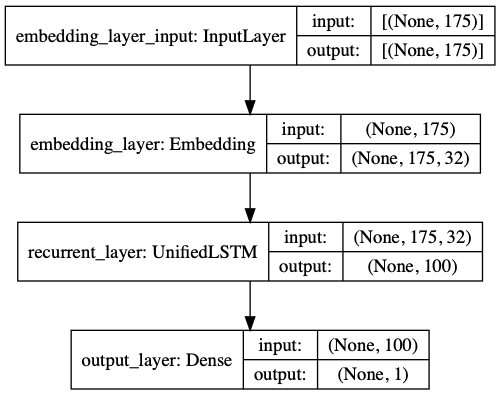

In [23]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')
plot_model(model2, show_shapes = True,  to_file='model2.png')
plot_model(model2, show_layer_names=True, to_file='model3.png')
plot_model(model, show_layer_names=True, show_shapes = True, to_file='model4.png')



In [24]:
#clustering

In [25]:
from sklearn.cluster import MiniBatchKMeans, DBSCAN, KMeans

def build_location(tokens):
    location = np.zeros(len(word_index2)+1)
    for x in tokens:
        if x in word_index2:
            i = word_index2[x]
            location[i] += 1
            
    return location

def location_wrapper(row):
    return build_location(row['token'])

In [26]:
word_index2 = set(neg_words['word'].append(pos_words['word']))
word_index2 = create_dict(word_index2, np.arange(1, len(word_index2)+1))
master['location'] = master.apply(location_wrapper, axis=1)

matrix = np.array([])
for x in master['location']:
    matrix = np.append(matrix, x)
    
matrix = matrix.reshape((master.shape[0],len(master['location'][0])))

In [27]:
cluster = KMeans(n_clusters=100)
hist = cluster.fit(matrix)

In [28]:
hist.labels_

array([16, 23, 96, ..., 74, 74, 74], dtype=int32)

In [29]:
#master.drop(columns=['group'])
master['group'] = hist.labels_
master

,Unnamed: 0,Text,Positive?,token,c_string,int_rep,location,group
0,0,أبذل الجهد و العرق و توكل على الله و اطمئن فر...,1.0,"[بذل, جهد, و, عرق, و, وكل, علي, الل, و, طمئ, ف...",بذلجهدوعرقووكلعلياللوطمئفرزقمضم,"[17, 3719, 2766, 1391, 2766, 2865, 2667, 2568,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",16
1,1,احُبك ربي,1.0,"[اح, , بك, ربي]",احبكربي,"[4154, 0, 791]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23
2,2,اللهم عفوك و رضاك و الجنه,1.0,"[لهم, عفو, و, رضا, و, جنه]",لهمعفوورضاوجنه,"[915, 2766, 2944, 2766, 4056]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96
3,3,الماء هى الحياة,1.0,"[ماء, هي, حيا]",ماءهيحيا,"[3476, 759]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",74
4,4,بالفعل لازم كل واحد بيتكلم عن الدين اقل مافيه...,1.0,"[فعل, لازم, كل, احد, بيتكلم, عن, دين, اقل, ماف...",فعللازمكلاحدبيتكلمعنديناقلمافيلتزمباقلمبادئعشا...,"[536, 1168, 2176, 537, 1444, 2735, 1843, 1242,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",58
5,5,بوركت جهودك و سلمت اناملك,1.0,"[بورك, جهود, و, سلم, انمل]",بوركجهودوسلمانمل,"[421, 3487, 2766, 3643, 1045]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96
6,6,سبحان القادر المقتدر بيده ملكوت كل شيء,1.0,"[سبح, قادر, مقتدر, بيد, ملكو, كل, شيء]",سبحقادرمقتدربيدملكوكلشيء,"[481, 1074, 157, 1441, 1484]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",74
7,7,قلوب العباد بين اصبعين من اصابع الرحمن,1.0,"[قلوب, عباد, بين, اصبع, من, اصبع, رحمن]",قلوبعبادبيناصبعمناصبعرحمن,"[699, 1443, 1731, 1731, 3733]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",74
8,8,لا اله الا الله اما من يتحرى الصدق يكتب عندا ...,1.0,"[لا, اله, الا, الل, اما, من, تحري, صدق, كتب, ع...",لاالهالااللامامنتحريصدقكتبعنداللصادق,"[1244, 1289, 2568, 1571, 4291, 813, 3880, 2568...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84
9,9,نسأل الله العفو و العافية,1.0,"[سال, الل, عفو, و, عافي]",سالاللعفووعافي,"[1698, 2568, 915, 2766, 423]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17


In [43]:
from googletrans import Translator
translator = Translator()

def trans(string):
    x = translator.translate(string)
    return x.text


def translate_wrapper(row):
    return trans(row['Text'])

def get_grouping(group_num, how_many=0):
    if how_many == 0:
        temp = master[master['group'] == group_num]
        temp = temp.drop(columns =  ['Positive?', "token", 'c_string', 'int_rep', 'group', 'location'])
        temp['translation'] = temp.apply(translate_wrapper, axis =1)
        return temp
    else:
        temp = master[master['group'] == group_num][:how_many]
        temp = temp.drop(columns =  ['Positive?', "token", 'c_string', 'int_rep', 'group', 'location'])
        temp['translation'] = temp.apply(translate_wrapper, axis =1)
        return temp

def get_grouping_sized():
    dic = {}
    for x in master['group']:
        if x in dic:
            dic[x] += 1
        else:
            dic[x] = 1
    return dic

In [31]:
get_grouping_sized()

{16: 10,
 23: 17,
 96: 131,
 74: 873,
 58: 28,
 84: 25,
 17: 46,
 11: 13,
 34: 175,
 66: 27,
 65: 41,
 28: 61,
 19: 137,
 37: 31,
 91: 1,
 21: 6,
 87: 1,
 14: 50,
 42: 25,
 80: 1,
 62: 15,
 81: 7,
 29: 1,
 95: 6,
 39: 26,
 77: 2,
 46: 1,
 2: 22,
 70: 8,
 0: 8,
 30: 12,
 57: 19,
 35: 17,
 53: 3,
 32: 2,
 55: 1,
 88: 1,
 71: 1,
 78: 1,
 73: 4,
 83: 1,
 76: 1,
 64: 1,
 69: 1,
 43: 1,
 93: 2,
 10: 1,
 90: 1,
 31: 2,
 72: 1,
 9: 1,
 98: 1,
 67: 21,
 38: 2,
 15: 20,
 49: 9,
 45: 18,
 22: 1,
 68: 1,
 36: 2,
 7: 1,
 82: 2,
 97: 1,
 85: 1,
 52: 1,
 6: 1,
 99: 1,
 33: 1,
 8: 4,
 18: 1,
 40: 1,
 13: 4,
 47: 2,
 20: 1,
 48: 1,
 41: 2,
 44: 2,
 63: 1,
 75: 3,
 54: 1,
 26: 1,
 89: 1,
 59: 2,
 50: 1,
 60: 1,
 4: 2,
 5: 2,
 1: 2,
 86: 1,
 56: 1,
 92: 1,
 24: 1,
 51: 2,
 94: 1,
 3: 1,
 79: 1,
 61: 1,
 25: 1,
 27: 2,
 12: 2}

In [45]:
temp = get_grouping(21)
#for x in temp['translation']:
 #   print(x)
    
for x in temp['translation']:
    print(x)

He is non-Muslim and knows his heart fulfilled, how the Muslims, O Allah, give the daughters of Muslims a good loving husband like him
O Allah, give the sons of Muslims good wives and daughters of Muslims, good husbands
Oh Allah, grant us a good companionship
Oh God, provide us with a valid livelihood
Oh God, give us a good loving husband like
Blessings O God, we have a good husband who knows the meaning of Rafqa bottles
